# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [32]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [33]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [34]:
from cs231n.features import *

num_color_bins = 30 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [37]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
regularization_strengths = [1e-3, 1e-2, 1e-1, 0.5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                  num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_accr = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accr = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accr, val_accr)
        
        if val_accr > best_val:
            best_svm = svm
            best_val = val_accr

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 8.987876
iteration 100 / 1500: loss 8.920221
iteration 200 / 1500: loss 8.857770
iteration 300 / 1500: loss 8.780306
iteration 400 / 1500: loss 8.717665
iteration 500 / 1500: loss 8.557760
iteration 600 / 1500: loss 8.559408
iteration 700 / 1500: loss 8.410022
iteration 800 / 1500: loss 8.322215
iteration 900 / 1500: loss 8.332271
iteration 1000 / 1500: loss 8.231723
iteration 1100 / 1500: loss 8.277691
iteration 1200 / 1500: loss 8.082098
iteration 1300 / 1500: loss 8.153261
iteration 1400 / 1500: loss 7.830545
iteration 0 / 1500: loss 9.003035
iteration 100 / 1500: loss 8.924731
iteration 200 / 1500: loss 8.847818
iteration 300 / 1500: loss 8.800512
iteration 400 / 1500: loss 8.685715
iteration 500 / 1500: loss 8.621833
iteration 600 / 1500: loss 8.513966
iteration 700 / 1500: loss 8.489574
iteration 800 / 1500: loss 8.411672
iteration 900 / 1500: loss 8.292054
iteration 1000 / 1500: loss 8.235109
iteration 1100 / 1500: loss 8.148415
iteration 1200 / 1500: lo

iteration 200 / 1500: loss 4.002626
iteration 300 / 1500: loss 3.714364
iteration 400 / 1500: loss 4.086031
iteration 500 / 1500: loss 4.074001
iteration 600 / 1500: loss 4.054992
iteration 700 / 1500: loss 4.451298
iteration 800 / 1500: loss 3.804288
iteration 900 / 1500: loss 4.470099
iteration 1000 / 1500: loss 4.052458
iteration 1100 / 1500: loss 4.219938
iteration 1200 / 1500: loss 3.963710
iteration 1300 / 1500: loss 4.060716
iteration 1400 / 1500: loss 3.792798
iteration 0 / 1500: loss 8.972708
iteration 100 / 1500: loss 3.320011
iteration 200 / 1500: loss 3.200824
iteration 300 / 1500: loss 3.366513
iteration 400 / 1500: loss 3.133456
iteration 500 / 1500: loss 2.573226
iteration 600 / 1500: loss 3.575061
iteration 700 / 1500: loss 3.272451
iteration 800 / 1500: loss 2.936569
iteration 900 / 1500: loss 3.117406
iteration 1000 / 1500: loss 2.925704
iteration 1100 / 1500: loss 3.524170
iteration 1200 / 1500: loss 3.466671
iteration 1300 / 1500: loss 3.095595
iteration 1400 / 1500

In [38]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.501


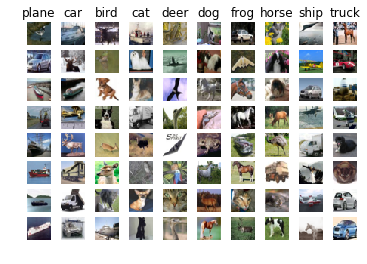

In [23]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [39]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 175)
(49000, 174)


In [44]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
regs = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]


net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
max_val_acc = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1000, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            best_net = net
            
        print("lr: %e, reg: %e, val: %f" % (lr, reg, val_acc))
            
print(max_val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302585
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302585
iteration 500 / 1000: loss 2.302585
iteration 600 / 1000: loss 2.302585
iteration 700 / 1000: loss 2.302585
iteration 800 / 1000: loss 2.302585
iteration 900 / 1000: loss 2.302585
lr: 1.000000e-07, reg: 1.000000e-07, val: 0.113000
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302585
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302585
iteration 500 / 1000: loss 2.302585
iteration 600 / 1000: loss 2.302585
iteration 700 / 1000: loss 2.302585
iteration 800 / 1000: loss 2.302585
iteration 900 / 1000: loss 2.302585
lr: 1.000000e-07, reg: 1.000000e-06, val: 0.106000
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302585
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302585
iter

iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302583
iteration 300 / 1000: loss 2.302581
iteration 400 / 1000: loss 2.302581
iteration 500 / 1000: loss 2.302582
iteration 600 / 1000: loss 2.302589
iteration 700 / 1000: loss 2.302583
iteration 800 / 1000: loss 2.302582
iteration 900 / 1000: loss 2.302586
lr: 1.000000e-04, reg: 1.000000e-05, val: 0.078000
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302586
iteration 300 / 1000: loss 2.302588
iteration 400 / 1000: loss 2.302584
iteration 500 / 1000: loss 2.302583
iteration 600 / 1000: loss 2.302587
iteration 700 / 1000: loss 2.302579
iteration 800 / 1000: loss 2.302589
iteration 900 / 1000: loss 2.302588
lr: 1.000000e-04, reg: 1.000000e-04, val: 0.079000
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 2.302586
iteration 200 / 1000: loss 2.302587
iteration 300 / 1000: loss 2.302588
iteration 400 / 1000: loss 2.302589
iteration 500 / 1000: loss 2.302584
it

iteration 200 / 1000: loss 2.155508
iteration 300 / 1000: loss 1.775753
iteration 400 / 1000: loss 1.677810
iteration 500 / 1000: loss 1.386509
iteration 600 / 1000: loss 1.512105
iteration 700 / 1000: loss 1.364935
iteration 800 / 1000: loss 1.300227
iteration 900 / 1000: loss 1.293967
lr: 1.000000e-01, reg: 1.000000e-03, val: 0.522000
iteration 0 / 1000: loss 2.302594
iteration 100 / 1000: loss 2.302433
iteration 200 / 1000: loss 2.194102
iteration 300 / 1000: loss 1.883972
iteration 400 / 1000: loss 1.841348
iteration 500 / 1000: loss 1.711584
iteration 600 / 1000: loss 1.596763
iteration 700 / 1000: loss 1.475143
iteration 800 / 1000: loss 1.583268
iteration 900 / 1000: loss 1.540496
lr: 1.000000e-01, reg: 1.000000e-02, val: 0.510000
0.522


In [45]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.518
